   ## Telco Customer Churn

Dataset from Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn

The objective is to predict churn (i.e. if a costumer drops out), which is a widely used metric in subscription based services such as internet/tv providers, insurance and streaming services (youtube, netflix, hulu, etc).  

I will start by getting an overview of the data and then proceed to do some EDA before predicting the churn.

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [238]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [239]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


We have self-explanatory column names. 
`Tenure` is measured in months

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

First it appears we don't have missing values, but TotalCharges is not supposed to be categorical (turns out it has 11 empty observations) 

In [241]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [242]:
df.TotalCharges.isnull().mean()

0.001561834445548772

This is a marginal percentage of missing values, let's just delete them

In [243]:
df = df.dropna()

In [244]:
df.TotalCharges.isnull().sum()

0

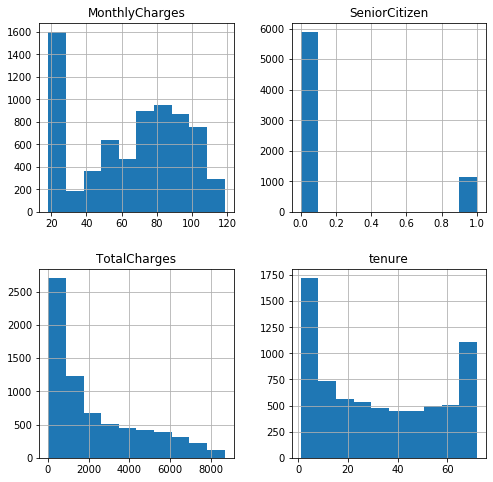

In [245]:
df.hist(figsize=(8,8));

In [246]:
df.DeviceProtection.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [247]:
df.Contract.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

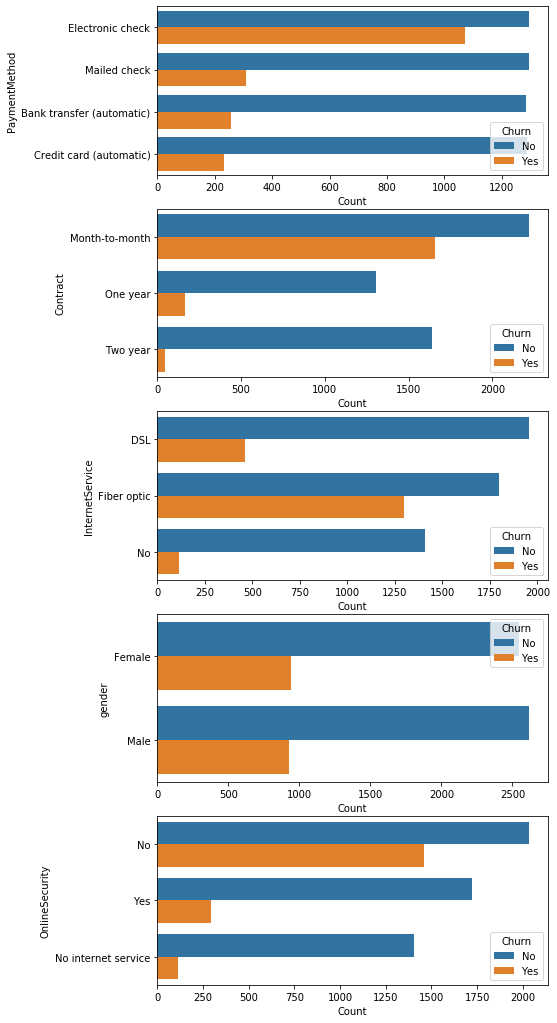

In [248]:
columns_plot = ['PaymentMethod', 'Contract', 'InternetService', 'gender', 'OnlineSecurity']
 
plt.figure(figsize=(7, 18))

for ind,col in enumerate(columns_plot):
    plt.subplot(5, 1, ind+1)
    sns.countplot(y=col, data=df, hue="Churn");
    plt.xlabel('Count')

In `InternetService`, we can see the churn being higher in Fiber Optic clients than DSL and no internet clients. This can be due to more competitive campaigns in the fiber optics "market" but another plausible (and perhaps more probable) explanation is that the churn varies because of the client profile that subscribes this types of services - i.e. this services may be a proxy for client location etc

Looking at `Contract` , as we would expect, the longer the contract the smaller the churn. 

Regarding `PaymentMethod`, automatic payment wins in the "keeping customers championship". Costumers with eletronic payment with churn numbers going through the roof. 

`gender` doens't look promissing for our purpose 

`Online Security` is one of many *ternary* columns. It looks pretty important. 


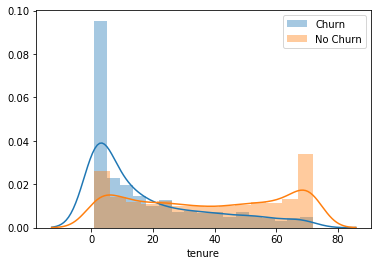

In [249]:
sns.distplot(df.tenure[df.Churn == 'Yes'], label='Churn')
sns.distplot(df.tenure[df.Churn == 'No'], label='No Churn')
plt.xlabel('tenure')
plt.legend()
plt.show()

Has we can see above, `Tenure` is another important feature to understand Churn. In low tenure, churn is very high and steadily decreases as tenure gets higher.

A fantastic way to fight churn appears to be to focus on retaining early costumers.  

Moving on, we have a few binary columns that we can encode. There are a few columns that appeared to be binary but there's actualy a third option which is "no internet"

In [250]:
#checking binnary columns
binary_cols = [col for col in df if len(df[col].unique()) == 2]
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [251]:
#encoding the binary variables
le = LabelEncoder()

for col in binary_cols:
    df[col] = le.fit_transform(df[col])

"Yes" turned into `1` and "No" into `0`

"Male" into `1`, "Female" into `0`

Something interesting is to use the ternary columns (which represent online services) to create a new column that represents the number of services each custumer has. (If no internet -> 0 services)

In [252]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [253]:
ternary_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df["NumberServices"] = (df[ternary_cols] == 'Yes').sum(axis=1)

In [254]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumberServices
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,No,...,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,Yes,...,No,No,No,One year,0,Mailed check,56.95,1889.50,0,2
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,Yes,...,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,Yes,...,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,3
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,No,...,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,0


Let's test the categorical features for independence.

The null hypothesis is that the actual frequencies for a categorical feature are similar to the expected frequencies for that categorical feature.

In [255]:
#we don't need customerID anymore
df.drop("customerID", axis=1, inplace=True)

In [256]:
data_cat = df.select_dtypes(include=["object"])

for col in data_cat.columns:
    
    table = pd.crosstab(data_cat[col], df.Churn)

    display(table)
    chi2, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    #display(pd.DataFrame({'Column1': expected_table[:, 0], 'Column2': expected_table[:, 1]}))
    print(f"{col} p-value -> {pval:.3f}")

Churn,0,1
MultipleLines,,
No,2536,849
No phone service,510,170
Yes,2117,850


MultipleLines p-value -> 0.004


Churn,0,1
InternetService,,
DSL,1957,459
Fiber optic,1799,1297
No,1407,113


InternetService p-value -> 0.000


Churn,0,1
OnlineSecurity,,
No,2036,1461
No internet service,1407,113
Yes,1720,295


OnlineSecurity p-value -> 0.000


Churn,0,1
OnlineBackup,,
No,1854,1233
No internet service,1407,113
Yes,1902,523


OnlineBackup p-value -> 0.000


Churn,0,1
DeviceProtection,,
No,1883,1211
No internet service,1407,113
Yes,1873,545


DeviceProtection p-value -> 0.000


Churn,0,1
TechSupport,,
No,2026,1446
No internet service,1407,113
Yes,1730,310


TechSupport p-value -> 0.000


Churn,0,1
StreamingTV,,
No,1867,942
No internet service,1407,113
Yes,1889,814


StreamingTV p-value -> 0.000


Churn,0,1
StreamingMovies,,
No,1843,938
No internet service,1407,113
Yes,1913,818


StreamingMovies p-value -> 0.000


Churn,0,1
Contract,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48


Contract p-value -> 0.000


Churn,0,1
PaymentMethod,,
Bank transfer (automatic),1284,258
Credit card (automatic),1289,232
Electronic check,1294,1071
Mailed check,1296,308


PaymentMethod p-value -> 0.000


All these categorical features appear to have some relevant information to add

In [257]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumberServices
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,1
1,1,0,0,0,34,1,No,DSL,Yes,No,...,No,No,No,One year,0,Mailed check,56.95,1889.50,0,2
2,1,0,0,0,2,1,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,2
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,...,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,3
4,0,0,0,0,2,1,No,Fiber optic,No,No,...,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,0


We can create one more column. One that captures the relationship between the mean monthly charges and the current monthly charges. It could be interesting because this can captur if there's a correlation between the MonthlyCharges being above average vs churn happening.

In [258]:
df["DifferentialCharges"] = df.MonthlyCharges - (df.TotalCharges / df.tenure)

`Contract` feature could be encoded into a scale 1,2,3 "Month-to-month", "One year", "Two year" respectively. But since the features we have to OHE do not have too many unique values, we can OHE also the `Contract` feature

In [259]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NumberServices,DifferentialCharges
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,...,No,No,Month-to-month,1,Electronic check,29.85,29.85,0,1,0.000000
1,1,0,0,0,34,1,No,DSL,Yes,No,...,No,No,One year,0,Mailed check,56.95,1889.50,0,2,1.376471
2,1,0,0,0,2,1,No,DSL,Yes,Yes,...,No,No,Month-to-month,1,Mailed check,53.85,108.15,1,2,-0.225000
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,...,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,3,1.394444
4,0,0,0,0,2,1,No,Fiber optic,No,No,...,No,No,Month-to-month,1,Electronic check,70.70,151.65,1,0,-5.125000


In [260]:
cat_cols = df.select_dtypes(exclude=['int', 'float']).columns
cat_cols

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaymentMethod'],
      dtype='object')

In [261]:
df = pd.get_dummies(df, columns = cat_cols)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


_____________

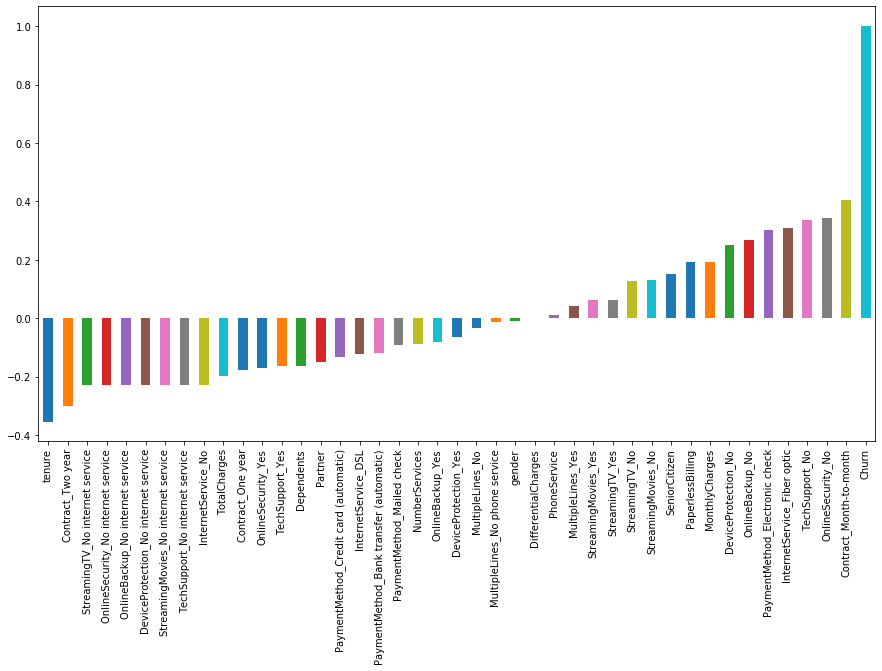

In [262]:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values().plot(kind='bar')

In [263]:
random = 10
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=random)

In [264]:
X_train = train_set.drop(['Churn'], axis = 1)
y_train = train_set['Churn']

X_test = test_set.drop(['Churn'], axis = 1)
y_test = test_set['Churn']

In [265]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

### SVM

In [266]:
clf_svm = SVC(random_state = random).fit(X_train, y_train)

In [267]:
y_preds = clf_svm.predict(X_test)

In [268]:
roc_svm = roc_auc_score(y_test, y_preds)
roc_svm

0.7152097689125703

In [269]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,1,All
Actual,,,
0,937,109,1046
1,168,193,361
All,1105,302,1407


In [270]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

In [271]:
score_data = [roc_svm, precision[1], recall[1], fscore[1]]
df_score = pd.DataFrame({'SVM': score_data},index = [ 'ROC AUC', 'Precision', 'Recall', 'F1score'])

df_score

,SVM
ROC AUC,0.715210
Precision,0.639073
Recall,0.534626
F1score,0.582202


## Logistic Regression

In [272]:
lr = LogisticRegression(random_state = random, max_iter = 1000).fit(X_train, y_train)

In [273]:
parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

In [274]:
clf_lr = GridSearchCV(lr, parameters, cv = 5).fit(X_train, y_train)

In [275]:
y_preds = clf_lr.predict(X_test)

In [276]:
roc_lr = roc_auc_score(y_test, y_preds)
roc_lr

0.7372724480013559

In [277]:
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,931,115,1046
1,150,211,361
All,1081,326,1407


In [278]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

score_data = [roc_lr, precision[1], recall[1], fscore[1]]

df_lr = pd.DataFrame({'Logistic Regression': score_data}, index=['ROC AUC', 'Precision', 'Recall', 'F1score'] )

df_score = pd.concat([df_score, df_lr], axis=1)
df_score

,SVM,Logistic Regression
ROC AUC,0.715210,0.737272
Precision,0.639073,0.647239
Recall,0.534626,0.584488
F1score,0.582202,0.614265


## KNN

In [279]:
knn = KNeighborsClassifier()

In [280]:
parameters = {'n_neighbors': range(1, 30, 1)}

In [281]:
clf_knn = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

In [282]:
y_preds = clf_knn.predict(X_test)
#accuracy_score(y_test, y_preds)

In [283]:
roc_knn = roc_auc_score(y_test, y_preds)
roc_knn

0.7317693574784299

In [284]:
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,905,141,1046
1,145,216,361
All,1050,357,1407


In [285]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

score_data = [roc_knn, precision[1], recall[1], fscore[1]]

df_knn = pd.DataFrame({'KNN': score_data}, index=['ROC AUC', 'Precision', 'Recall', 'F1score'] )

df_score = pd.concat([df_score, df_knn], axis=1)
df_score

,SVM,Logistic Regression,KNN
ROC AUC,0.715210,0.737272,0.731769
Precision,0.639073,0.647239,0.605042
Recall,0.534626,0.584488,0.598338
F1score,0.582202,0.614265,0.601671


## Decision Tree

In [286]:
clf_tree = tree.DecisionTreeClassifier(random_state = random)

parameters = {'max_depth': [4, 6, 10, 20], 'min_samples_split': [2, 4, 10]}

clf = GridSearchCV(clf_tree, parameters, cv = 5).fit(X_train, y_train)

In [287]:
y_preds = clf.predict(X_test)

In [288]:
roc_tree = roc_auc_score(y_test, y_preds)
roc_tree

0.6980132730941775

In [289]:
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,930,116,1046
1,178,183,361
All,1108,299,1407


In [290]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

score_data = [roc_tree, precision[1], recall[1], fscore[1]]

df_DT = pd.DataFrame({'DT': score_data}, index=['ROC AUC', 'Precision', 'Recall', 'F1score'] )

df_score = pd.concat([df_score, df_DT], axis=1)
df_score

,SVM,Logistic Regression,KNN,DT
ROC AUC,0.715210,0.737272,0.731769,0.698013
Precision,0.639073,0.647239,0.605042,0.612040
Recall,0.534626,0.584488,0.598338,0.506925
F1score,0.582202,0.614265,0.601671,0.554545


## Random Forest

In [291]:
clf_tree = RandomForestClassifier(random_state = random)

parameters = {'n_estimators': [10, 100, 300, 1200]}

clf_rf = GridSearchCV(clf_tree, parameters, cv = 5).fit(X_train, y_train)

In [292]:
y_preds = clf_rf.predict(X_test)

In [293]:
roc_rf = roc_auc_score(y_test, y_preds)
roc_rf

0.7183108848906004

In [294]:
clf_rf.score(X_test, y_test)

0.8009950248756219

In [295]:
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,929,117,1046
1,163,198,361
All,1092,315,1407


In [296]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

score_data = [roc_rf, precision[1], recall[1], fscore[1]]

df_fr = pd.DataFrame({'Random Forest': score_data}, index=['ROC AUC', 'Precision', 'Recall', 'F1score'] )

df_score = pd.concat([df_score, df_fr], axis=1)
df_score

,SVM,Logistic Regression,KNN,DT,Random Forest
ROC AUC,0.715210,0.737272,0.731769,0.698013,0.718311
Precision,0.639073,0.647239,0.605042,0.612040,0.628571
Recall,0.534626,0.584488,0.598338,0.506925,0.548476
F1score,0.582202,0.614265,0.601671,0.554545,0.585799


## Neural Network

In [297]:
mlp = MLPClassifier(random_state = random, max_iter = 2000)

parameters = {'hidden_layer_sizes': [(13), (13, 8), (13, 8, 2)], 'learning_rate_init': [0.00001, 0.001, 0.01, 0.1, 1]}

clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train, y_train)

In [298]:
y_preds = clf_mlp.predict(X_test)

In [299]:
roc_nn = roc_auc_score(y_test, y_preds)
roc_nn

0.7035653564826829

In [300]:
pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,959,87,1046
1,184,177,361
All,1143,264,1407


In [301]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_preds)

score_data = [roc_nn, precision[1], recall[1], fscore[1]]

df_nn = pd.DataFrame({'Neural Network': score_data}, index=['ROC AUC', 'Precision', 'Recall', 'F1score'])

df_score = pd.concat([df_score, df_nn], axis=1)
df_score

,SVM,Logistic Regression,KNN,DT,Random Forest,Neural Network
ROC AUC,0.715210,0.737272,0.731769,0.698013,0.718311,0.703565
Precision,0.639073,0.647239,0.605042,0.612040,0.628571,0.670455
Recall,0.534626,0.584488,0.598338,0.506925,0.548476,0.490305
F1score,0.582202,0.614265,0.601671,0.554545,0.585799,0.566400


_________